In [1]:
import numpy as np
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from scipy import stats
from collections import defaultdict

In [2]:
a = np.zeros((5, 5))
a[0,:] = np.inf
a[:,0] = np.inf
a[1, 1]

0.0

In [3]:
(1 - np.inf) ** 2

inf

In [2]:
class DTWBase(object):
    def __init__(self, arr1, arr2):
        self.arr1 = arr1
        self.arr2 = arr2
        self.n = len(arr1)
        self.m = len(arr2)
        self.warping_matrix = None
    def set_matrix(self):
        self.warping_matrix = np.zeros((self.n+1, self.m+1)) - 1
        self.warping_matrix[:,0] = np.inf
        self.warping_matrix[0,:] = np.inf
        self.warping_matrix[0,0] = 0
    def cost(self, i, j):
        return (self.arr1[i] - self.arr2[j]) ** 2
    def compute(self):
        for i in range(1,self.n+1):
            for j in range(1, self.m+1):
                d = self.cost(i-1, j-1)
                self.warping_matrix[i,j] = d + min(self.warping_matrix[i-1,j],
                                                   self.warping_matrix[i,j-1], 
                                                   self.warping_matrix[i-1,j-1])
    def find_path(self):
        n,m = self.warping_matrix.shape
        i = n-1
        j = m-1
        path = []
        while i != 0 and j != 0:
            path.append((i-1, j-1))
            vals = [self.warping_matrix[i-1,j], 
                    self.warping_matrix[i,j-1], 
                    self.warping_matrix[i-1,j-1]]
            idx = np.argmin(vals)
            if vals[0] == vals[1] and vals[0] == vals[2]:
                i -= 1
                j -= 1
            else:
                if idx == 0:
                    i -= 1
                elif idx == 1:
                    j -= 1
                elif idx == 2:
                    i -= 1
                    j -= 1
        return path[::-1]
    
    def distance(self):
        return self.warping_matrix[self.n,self.m]
    
    def paths(self):
        return self.warping_matrix

In [3]:
s1 = np.array([0,0,1,2,1,0,1,0,0,2,1,0,0], dtype=float)
s2 = np.array([0,1,2,3,1,0,0,0,2,1,0,0,0], dtype=float)

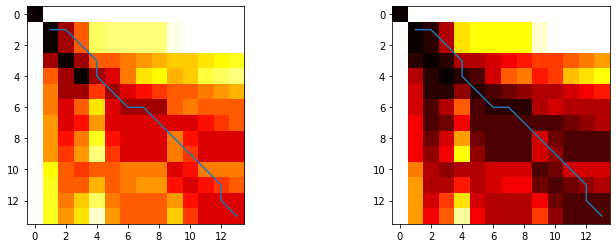

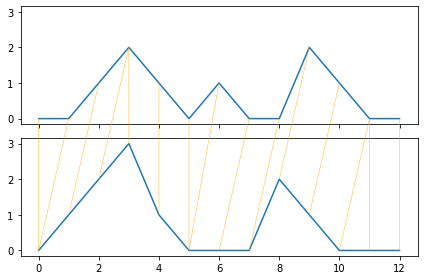

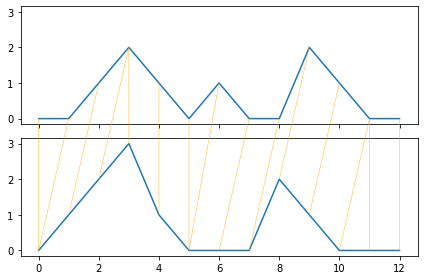

In [4]:
d1, paths1 = dtw.warping_paths(s1, s2)
path1 = dtw.warping_path(s1, s2)
x1, y1 = zip(*path1)

idtw = DTWBase(s1, s2)
idtw.set_matrix()
idtw.compute()
d2 = idtw.distance()
paths2 = idtw.paths()
path2 = idtw.find_path()
x2, y2 = zip(*path2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(paths1, cmap='hot', interpolation='nearest')
ax[0].plot(np.array(x1)+1, np.array(y1)+1)

ax[1].imshow(paths2, cmap='hot', interpolation='nearest')
ax[1].plot(np.array(x2)+1, np.array(y2)+1)


_ = dtwvis.plot_warping(s1, s2, path1)
_ = dtwvis.plot_warping(s1, s2, path2)

### Load irregular time series

In [5]:
data_path = os.path.join(str(os.getcwd()), '..', 'data')
df = pd.read_csv(os.path.join(data_path, "training_set.csv.zip"))
df_meta = pd.read_csv(os.path.join(data_path, "training_set_metadata.csv"))

In [6]:
df = df[df["passband"] == 5]
df_grouped = df.groupby(["object_id"])
detections = df_grouped["detected"].apply(sum)
detections[detections > 50]

object_id
615       52
4088      51
7315      53
12695     54
24903     56
          ..
312964    56
313565    54
314451    54
329326    51
331154    52
Name: detected, Length: 68, dtype: int64

In [7]:
df_meta2 = df_meta[df_meta["target"] == 90]
df_meta2 = df_meta2[df_meta2["ddf"] == 0]
objs = np.array(df_meta2["object_id"])
objs.shape

(1476,)

In [8]:
df2 = df[df["object_id"].isin(objs)]
df_grouped = df2.groupby(["object_id"])
detections = df_grouped["detected"].apply(sum)
detections[detections > 3]

object_id
2123138      4
11266451     7
12330041     4
16487008     6
17822141     4
            ..
125113440    4
125643018    4
128089118    4
129524163    7
130414189    8
Name: detected, Length: 64, dtype: int64

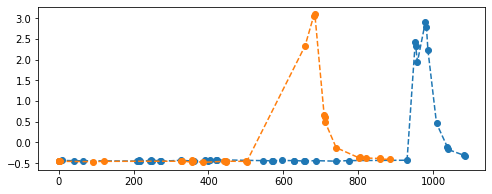

In [9]:
fluxes = df_grouped["flux"].apply(list)
times = df_grouped["mjd"].apply(list)
obj1 = 89325014
obj2 = 95151726
# obj1 = 11266451
# obj2 = 2123138
times1 = times.loc[obj1]
times1 = np.array(times1) - times1[0] 
times2 = times.loc[obj2]
times2 = np.array(times2) - times2[0]
fluxes1 = preprocessing.scale(fluxes.loc[obj1])
fluxes2 = preprocessing.scale(fluxes.loc[obj2])
plt.figure(figsize=(8,3))
plt.plot(times1, fluxes1, 'o--')
plt.plot(times2, fluxes2, 'o--')

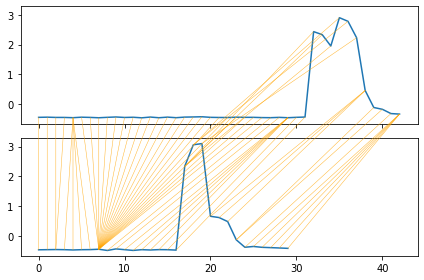

In [10]:
d1, paths1 = dtw.warping_paths(fluxes1, fluxes2)
path1 = dtw.warping_path(fluxes1, fluxes2)
x1, y1 = zip(*path1)

_ = dtwvis.plot_warping(fluxes1, fluxes2, path1)

In [107]:

def get_slope(times, fluxes):
    slope, intercept, r_value, p_value, std_err = stats.linregress(times,fluxes)
    return slope, intercept

def get_value(fluxes):
    return np.mean(fluxes)

def tva(times, fluxes, window):
    i = 0
    j = 1
    tva_vec = []
    ini_time = 0
    end_time = window
    while ini_time <  times[-1]:
        while times[i] < ini_time:
            i+=1
        while j < len(times) and times[j] < end_time:
            j+=1
#         print("window time:", ini_time, end_time, ", i:", i, ", j:", j)
        if j-i >= 1:
            time_seg = times[i:j]
            fluxes_seg = fluxes[i:j]
            if j-i > 1:
                slope, intercept = get_slope(time_seg, fluxes_seg)
            else:
                slope, intercept = 0, 0
            val = get_value(fluxes_seg)
            tva_vec.append((True,(slope, val, intercept, i, j, ini_time, end_time)))
        else:
            tva_vec.append((False, (ini_time, end_time)))
        ini_time += window
        end_time += window
        i = j-1
        
    return tva_vec

def tvia(times, fluxes, window, threshold=2):
	tva_vec = []
	ini_time = 0
	end_time = ini_time + window
	k = 0
	i = 0
	while k + threshold <=  len(fluxes):
		while times[k] <= end_time:
			if k == len(fluxes)-1:
				break
			k += 1
		if k - i >= threshold:
			time_seg = times[i:k]
			fluxes_seg = fluxes[i:k]
			if threshold > 1:
				slope,_ = get_slope(time_seg, fluxes_seg)
			else:
				slope = 0
			val = get_value(fluxes_seg)
			tva_vec.append((True, (slope, val, i, k, ini_time, end_time)))
		ini_time = times[k]
		end_time = ini_time + window
		i = k
		k += 1

	return tva_vec

In [108]:
window = 20
(times1[-1] - times1[0]) / window, (times2[-1] - times2[0]) / window

(54.19974999999977, 44.23775999999998)

In [109]:
tva1 = tva(times1, fluxes1, window)

In [110]:
def plot_tva(tva_values, times, fluxes):
    plt.figure(figsize=(14, 4))
    means = []
    instants = []
    for k in range(len(tva_values)):
        not_null, values = tva_values[k]
        if not_null:
            s, v, intercep, i, j, ini_time, end_time = values
            j = j-1
            x = np.linspace(ini_time, end_time)
            v_time = ini_time + (end_time - ini_time) / 2
            new_intercep = v - v_time*s
            y = x * s + new_intercep
            means.append(v)
            instants.append(v_time)
            plt.plot(x, y, '-b', linewidth=2)
            plt.axvspan(ini_time, end_time, alpha=0.3, color='green')
        else:
            ini_time, end_time = values
            plt.axvspan(ini_time, end_time, alpha=0.1, color='black')
#     x_min = (end_time - times1[i])/2
#     y_min = x_min * s + intercep
#     plt.plot([x_min], [y_min], 'ob', markersize=10)

    plt.plot(times, fluxes, '.-r', alpha=0.3)
    plt.plot(instants, means, 'ob', markersize=8)
    
def plot_tvia(tva_values, times, fluxes):
    plt.figure(figsize=(14, 4))
    means = []
    instants = []
    for k in range(len(tva_values)):
        not_null, values = tva_values[k]
        if not_null:
            s, v, i, j, ini_time, end_time = values
            x = np.linspace(ini_time, end_time)
            v_time = ini_time + (end_time - ini_time) / 2
            intercep = v - v_time*s
            y = x * s + intercep
            means.append(v)
            instants.append(v_time)
            plt.plot(x, y, '-b', linewidth=2)
            plt.axvspan(ini_time, end_time, alpha=0.3, color='green')
        else:
            ini_time, end_time = values
            plt.axvspan(ini_time, end_time, alpha=0.1, color='black')
#     x_min = (end_time - times1[i])/2
#     y_min = x_min * s + intercep
#     plt.plot([x_min], [y_min], 'ob', markersize=10)

    plt.plot(times, fluxes, '.-r', alpha=0.3)
    plt.plot(instants, means, 'ob', markersize=8)

(-35.0, 1153.9949999999953)

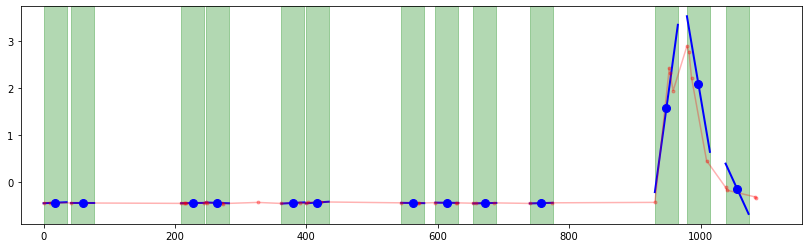

In [111]:
window = 35
tva1 = tvia(times1,fluxes1, window)
plot_tvia(tva1, times1, fluxes1)
plt.xlim([-window, max(times1[-1], times2[-1]) + window*2])

(-35.0, 1153.9949999999953)

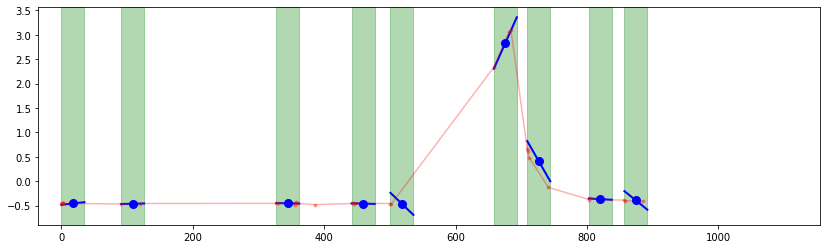

In [112]:
tva2 = tvia(times2, fluxes2, window)
plot_tvia(tva2, times2, fluxes2)
plt.xlim([-window, max(times1[-1], times2[-1]) + window*2])

In [79]:
class IrregularDTW(DTWBase):
    def __init__(self, arr1, arr2):
        super().__init__(arr1, arr2)
        self.valid_path_matrix = None
        
    def set_matrix(self):
        super(IrregularDTW, self).set_matrix()
        self.valid_path_matrix = np.ones(self.warping_matrix.shape)
        
    
    def cost(self, i, j):
        d = 0
        if self.arr1[i] is not None and self.arr2[j] is not None:
            for k in range(2):
                d += (self.arr1[i][k] - self.arr2[j][k]) ** 2
        return d
    
    def path_step_status(self, i, j):
        c1 = self.arr1[i] is None
        c2 = self.arr2[j] is None
#         if (c1 and not c2) or (not c1 and c2):
        if c1 or c2:
            return 0
        else:
            return 1
        
    def get_prev_valid_i(self, i, j):
        prev_i = i - 1
        while not self.valid_path_matrix[prev_i, j]:
            prev_i -= 1
        return prev_i
    
    def get_prev_valid_j(self, i, j):
        prev_j = j - 1
        while not self.valid_path_matrix[i, prev_j]:
            prev_j -= 1
        return prev_j
    
    def get_prev_valid_diag(self, i_ini, i_end, j_ini, j_end):    
        i = i_end - 1 
        highest_pair = [0,0]
        while i >= i_ini:
            j = j_end - 1
            while j >= j_ini:
                if self.valid_path_matrix[i,j]:
                    if i + j >= highest_pair[0] + highest_pair[1]:
                        highest_pair = [i, j]
                j -= 1
            i -= 1
        return highest_pair
    
    def compute(self):
        for i in range(1, self.n+1):
            for j in range(1, self.m+1):
                self.valid_path_matrix[i,j] = self.path_step_status(i-1, j-1)              
        
        for i in range(1,self.n+1):
            for j in range(1, self.m+1):
                if self.valid_path_matrix[i,j]:
                    prev_i = self.get_prev_valid_i(i, j)
                    prev_j = self.get_prev_valid_j(i, j)
#                     prev_i2, prev_j2 = self.get_prev_valid_diag(prev_i,i,prev_j,j)
                    prev_i2, prev_j2 = prev_i, prev_j
#                 print("Step: (%d,%d), prev_i: %d, prev_j: %d" % (i, j, prev_i, prev_j))
                    d = self.cost(i-1, j-1)
                    self.warping_matrix[i,j] = d + min(self.warping_matrix[prev_i,j],
                                                   self.warping_matrix[i,prev_j], 
                                                   self.warping_matrix[prev_i2,prev_j2])
                
    def find_path(self):
        n,m = self.warping_matrix.shape
        i = n-1
        j = m-1
        while self.arr1[i-1] is None:
            i -= 1
        while self.arr2[j-1] is None:
            j -= 1
            
        
        path = []
#         print("start:", i, j, "value:", self.warping_matrix[i,j])
        while i!=0 and j!=0:
            print(i, j, self.warping_matrix[i,j])
            if True:
                path.append((i-1, j-1))
                
            prev_i = self.get_prev_valid_i(i, j)
            prev_j = self.get_prev_valid_j(i, j)
#             prev_i2, prev_j2 = self.get_prev_valid_diag(prev_i, i, prev_j, j)
            prev_i2, prev_j2 = prev_i, prev_j
                
#             print("current: ", i, j)
#             print("-->[i, prev_j]=[%d,%d], val: %s" % (i, prev_j, str(self.warping_matrix[i, prev_j])))
#             print("-->[prev_i,j]=[%d,%d], val: %s" %(prev_i, j, str(self.warping_matrix[prev_i, j])))
#             print("-->[prev_i,prev_j]=[%d,%d], val: %s" % (prev_i2, prev_j2, str(self.warping_matrix[prev_i2, prev_j2])))
            
            vals = [self.warping_matrix[prev_i,j], 
                    self.warping_matrix[i,prev_j], 
                    self.warping_matrix[prev_i2,prev_j2]]
            idx = np.argmin(vals)
            if vals[0] == vals[1] and vals[0] == vals[2]:
                i = prev_i2
                j = prev_j2
            else:
                if idx == 0:
                    i = prev_i
                elif idx == 1:
                    j = prev_j
                elif idx == 2:
                    i = prev_i2
                    j = prev_j2
        return path[::-1]
    
    def plot_path(self, window):
        fig = plt.figure(constrained_layout=False, figsize=(10, 6))
        gs = fig.add_gridspec(11, 1)
        ax1 = fig.add_subplot(gs[0:4, :])
        ax1.xaxis.tick_top()
        n = len(self.arr1)
        ticks = []
        tickslabels = []
        for i in range(n):
            ini_time = i*window
            end_time = (i+1)*window
            if self.arr1[i] is not None:
                s, v, idx = self.arr1[i]
#                 ini_time = idx*window
#                 end_time = (idx + 1)*window
                x = np.linspace(ini_time, end_time)
                
                v_time = ini_time + (end_time - ini_time) / 2
                intercep = v - v_time*s
                y = x*s + intercep
                ax1.plot(x, y, '-b', linewidth=2)
                ax1.axvspan(ini_time, end_time, alpha=0.3, color='green')
                ticks.append(v_time)
                tickslabels.append(i)
            else:
                ax1.axvspan(ini_time, end_time, alpha=0.1, color='black')
                
        n1 = idx
        ax1.set_xticks(ticks)
        ax1.set_xticklabels(tickslabels, minor=False)
        
        
        ax3 = fig.add_subplot(gs[7:11, :])
        
        n = len(self.arr2)
        ticks = []
        tickslabels = []
        for i in range(n):
            ini_time = i*window
            end_time = (i+1)*window
            if self.arr2[i] is not None:
                s, v, idx = self.arr2[i]
#                 ini_time = idx*window
#                 end_time = (idx+1)*window
                x = np.linspace(ini_time, end_time)
                
                v_time = ini_time + (end_time - ini_time) / 2
                intercep = v - v_time*s
                y = x*s + intercep
                ax3.plot(x, y, '-b', linewidth=2)
                ax3.axvspan(ini_time, end_time, alpha=0.3, color='green')
                ticks.append(v_time)
                tickslabels.append(i)
            else:
                ax3.axvspan(ini_time, end_time, alpha=0.1, color='black')
        n2 = idx
        ax3.set_xticks(ticks)
        ax3.set_xticklabels(tickslabels, minor=False)
        
        
        n = max(n1 + 1, n2+1)
        n = max(len(self.arr1), len(self.arr2))
        
        ax1.set_xlim([0, n*window])
        ax3.set_xlim([0, n*window])
        
        ax2 = fig.add_subplot(gs[4:7, :])
        axR = ax2.twiny()
        ax2.set_xlim([0, n*window])
        axR.set_xlim([0, n*window])
        ax2.set_ylim([0, 1])
        ax2.axes.get_yaxis().set_visible(False)
        ax2.set_xticks(np.arange(n) * window  + window / 2)
        axR.set_xticks(np.arange(n) * window  + window / 2)
        ax2.set_xticklabels([])
        axR.set_xticklabels([])
        
        path = self.find_path()
        for k in range(len(path)):
            i,j = path[k]
#             _,_,i = self.arr1[i]
#             _,_,j = self.arr2[j]
            ax2.plot([j*window + window/2, i*window + window /2], [0, 1], color="orange")

In [80]:
arr_tva1 = []
for i in range(len(tva1)):
    valid, values = tva1[i]
    if valid:
        s, v, intercep, i, j, ini_time, end_time = values
        arr_tva1.append([s, v, i])
#     else:
#         arr_tva1.append(None)
        
arr_tva2 = []
for i in range(len(tva2)):
    valid, values = tva2[i]
    if valid:
        s, v, intercep, i, j, ini_time, end_time = values
        arr_tva2.append([s, v, i])
#     else:
#         arr_tva2.append(None)
        
# print(arr_tva2)

In [81]:
idtw = IrregularDTW(arr_tva1, arr_tva2)
idtw.set_matrix()
# print(idtw.paths(), idtw.paths()[1, 1])
idtw.compute()
# print(idtw.paths()[idtw.paths().shape[0]-4:, idtw.paths().shape[1]-4:])

In [82]:
b = 4
c = 5
a = [b, c-1]
b, c = a
b, c

(4, 4)

In [83]:
print(idtw.valid_path_matrix[-8:,-8:])
# print(idtw.valid_path_matrix[33, 23])
d2 = idtw.distance()
paths2 = idtw.paths()
path2 = idtw.find_path()

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
21 16 2.008969580468893
21 15 2.0006540306876404
21 14 1.9955718503027182
21 13 1.9922671146799447
20 12 1.9897590633952371
19 11 1.9886227018760476
18 10 0.46686170727825643
18 9 0.010382588584120776
17 8 0.005178238484187119
16 7 0.0038705574822391112
15 6 0.003474758598945511
15 5 0.0026384923480930315
14 4 0.0024750107539189344
13 4 0.002386459910736126
12 4 0.002336575432299379
11 4 0.002207824865453172
10 4 0.002146064797138865
9 4 0.0020421304802889576
8 4 0.0014433644983976783
7 4 0.0013184392882074094
6 4 0.0012549126113406298
5 4 0.0009249375887283983
4 4 0.0008341286970832676
3 3 0.000769687751858051
3 2 0.0007400343418579082
2 1 0.0005387417974748838
1 1 0.00035973963620232127


21 16 2.008969580468893
21 15 2.0006540306876404
21 14 1.9955718503027182
21 13 1.9922671146799447
20 12 1.9897590633952371
19 11 1.9886227018760476
18 10 0.46686170727825643
18 9 0.010382588584120776
17 8 0.005178238484187119
16 7 0.0038705574822391112
15 6 0.003474758598945511
15 5 0.0026384923480930315
14 4 0.0024750107539189344
13 4 0.002386459910736126
12 4 0.002336575432299379
11 4 0.002207824865453172
10 4 0.002146064797138865
9 4 0.0020421304802889576
8 4 0.0014433644983976783
7 4 0.0013184392882074094
6 4 0.0012549126113406298
5 4 0.0009249375887283983
4 4 0.0008341286970832676
3 3 0.000769687751858051
3 2 0.0007400343418579082
2 1 0.0005387417974748838
1 1 0.00035973963620232127


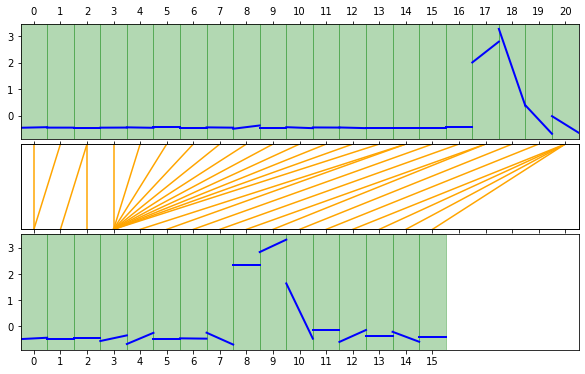

In [84]:
idtw.plot_path(window)
# print(path2)